# 0. Imports

## 0.2. Installing libraries (Only for Google Colab)

In [41]:
#!pip3 install inflection;
#!pip3 install boruta;

## 0.1. Helper Functions

In [42]:
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import datetime
from scipy import stats as ss
import pickle

import sklearn.linear_model as lm
import sklearn.metrics as mt
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
import xgboost as xgb
import gc

In [43]:
#plt.rcParams['figure.figsize'] = [18, 6]
plt.rcParams['font.size'] = 8

In [44]:
def ml_error(model_name, y, yhat):
    mae = mt.mean_absolute_error(y, yhat)
    mape = mt.mean_absolute_percentage_error(y, yhat)
    rmse = mt.mean_squared_error(y, yhat, squared=False)
    mpe = np.mean((y - yhat) / y)


    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse,
                         'MPE': mpe},
                         index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=False):

  mae_list = []
  mape_list = []
  rmse_list = []

  for k in reversed(range(1, kfold + 1)):
    if verbose == True:
      print(f'KFold number: {k}')
    # start and end date for validation
    validation_start_date = x_training['date'].max() - datetime.timedelta(days= k * 6 * 7)
    validation_end_date = x_training['date'].max() - datetime.timedelta(days= (k - 1) * 6 * 7)

    # filtering dataset
    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

    # training and validation dataset
    xtraining = training.drop(['date', 'sales'], axis = 1)
    ytraining = training['sales']

    xvalidation = validation.drop(['date', 'sales'], axis = 1)
    yvalidation = validation['sales']

    # model
    m = model
    m.fit(xtraining, ytraining)

    # prediction
    yhat = m.predict(xvalidation)

    # performance
    result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

    # store performance of each kfold iteration
    mae_list.append(result['MAE'])
    mape_list.append(result['MAPE'])
    rmse_list.append(result['RMSE'])

  return pd.DataFrame({'Model Name': model_name,
                       'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                       'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                       'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

## 0.2. Loading Data

In [45]:
# Only in Colab
#from google.colab import files
#files=files.upload()

In [46]:
df_sales_raw = pd.read_csv('../datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../datasets/store.csv', low_memory=False)
#df_sales_raw = pd.read_csv('train.csv', low_memory=False)
#df_store_raw = pd.read_csv('store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left',on='Store')

# deleting old df
del [df_sales_raw, df_store_raw]

In [47]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1. Descrição do Dados

In [48]:
df1 = df_raw.copy()
del df_raw

df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1. Rename Columns

In [49]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# Função para colocar underscore para separar palavras
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))           # O map passa os valores de cols_old para a função snakecase

df1.columns = cols_new

## 1.2. Data Dimension

In [50]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 1017209
Number of columns: 18


## 1.3. Data Types

In [51]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [52]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fill out NA

In [53]:
#competition_distance - substituir os valores faltantes por distâncias muito grandes, indicando que não há competidores próximos
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if pd.isna(x)==True else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if pd.isna(x['competition_open_since_month'])==True
                                                                          else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if pd.isna(x['competition_open_since_year'])==True
                                                                          else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if pd.isna(x['promo2_since_week'])==True
                                                                          else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if pd.isna(x['promo2_since_year'])==True
                                                                          else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1: 'Jan',
             2: 'Feb',
             3: 'Mar',
             4: 'Apr',
             5: 'May',
             6: 'Jun',
             7: 'Jul',
             8: 'Aug',
             9: 'Sep',
             10: 'Oct',
             11: 'Nov',
             12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0
                                                   else 1 if x['month_map'] in x['promo_interval'].split(',')
                                                   else 0, axis=1)

## 1.6. Change Types

In [54]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistical

In [55]:
# Split dataframe into numerical and categorical attributes
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [56]:
metrics = num_attributes.describe().T
metrics['median'] = num_attributes.median()
metrics['range'] = metrics['max'] - metrics['min']
metrics['skew'] = num_attributes.skew()
metrics['kurtosis'] = num_attributes.kurtosis()
metrics

,count,mean,std,min,25%,50%,75%,max,median,range,skew,kurtosis
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0,558.0,1114.0,-0.000955,-1.200524
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0,4.0,6.0,0.001593,-1.246873
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0,5744.0,41551.0,0.641460,1.778375
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0,609.0,7388.0,1.598650,7.091773
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.758045,1.090723
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.487838,-1.762018
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.677842,0.815154
competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0,2330.0,199980.0,10.242344,147.789712
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0,7.0,11.0,-0.042076,-1.232607
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0,2012.0,115.0,-7.235657,124.071304


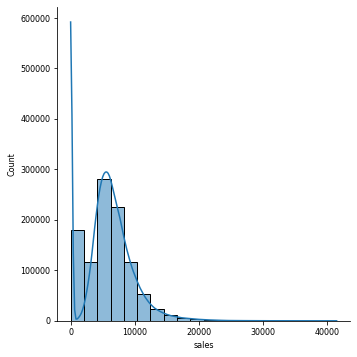

In [57]:
sns.displot(df1['sales'], kde=True, bins=20)

### 1.7.1. Categorical Attributes

In [58]:
cat_attributes.nunique()

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

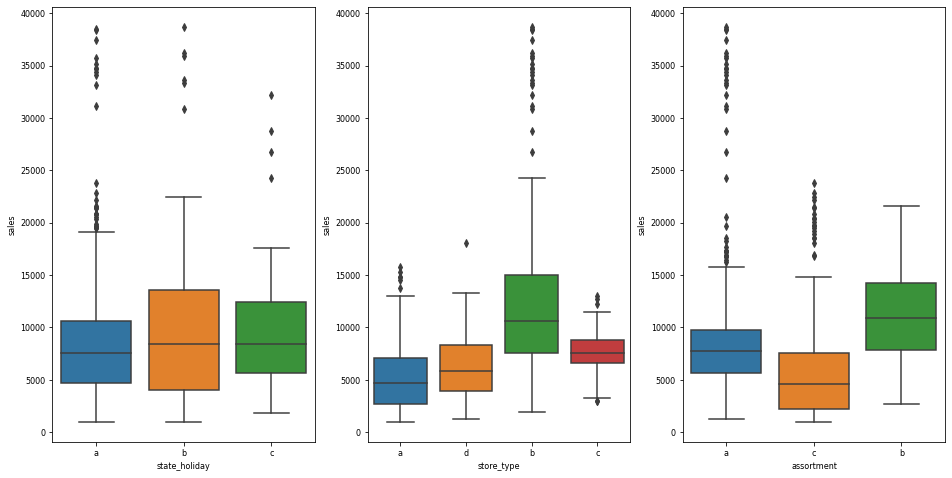

In [59]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(16,8))
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

In [60]:
del cat_attributes
gc.collect()

65

# 2. Feature Engineering

In [61]:
df2 = df1.copy()
del df1

## 2.1. Mapa mental de hipóteses

Hipóteses são apostas:
* Lojas de MAIOR porte deveriam vender MAIS
* Lojas com MAIOR sortimento deveriam vender MAIS
* Lojas com MAIS competidores perto deveriam vender MENOS

![image.png](attachment:image.png)

## 2.2. Criação das hipóteses

### 2.2.1. Hipóteses Lojas

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque maior deveriam vendem mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

### 2.2.2. Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expoem mais produtos na vitrine deveriam vender mais.

**3.** Lojas com menores preços deveriam vender mais.

**4.** Lojas com preços menores por mais tempo deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.2.4. Lista Final de Hipóteses

Baseando-se nos dados disponíveis, fazer uma lista possível de hipóteses:

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [62]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of the year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).dt.days.astype(int)

# primo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1','%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).dt.days.astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3. Filtragem de Variáveis

In [63]:
df3 = df2.copy()
#del df2
#gc.collect()

36

In [64]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.1. Filtragem das Linhas

In [65]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das Colunas

In [66]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop,axis=1)

# 4. Análise Exploratória dos Dados

In [67]:
df4 = df3.copy()
#del df3
#gc.collect()

0

## 4.1. Análise Univariada

### 4.1.1. Response variable

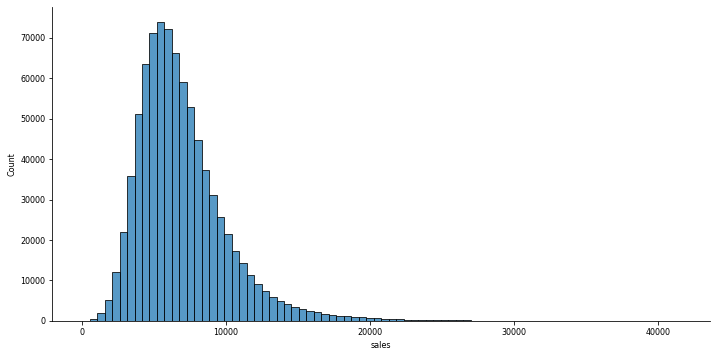

In [68]:
sns.displot(df4['sales'], bins=80, height=5, aspect=2)

### 4.1.2. Numerical variable

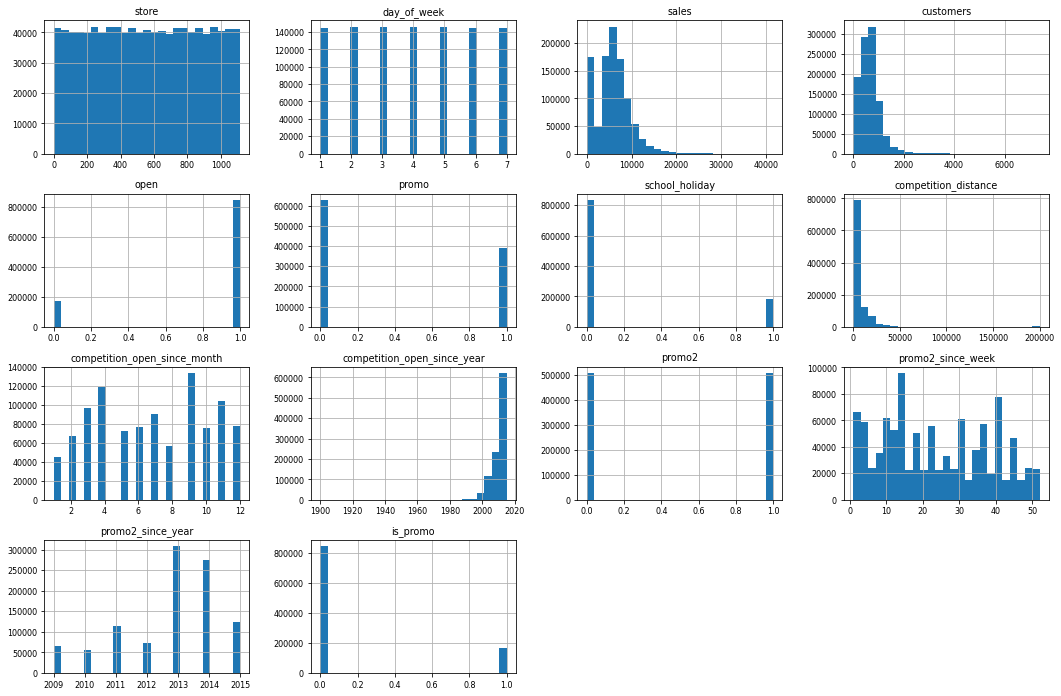

In [69]:
num_attributes.hist(bins=25, figsize=(18,12));
# Analisar os comportamentos das variáveis. Ver se ela "conta uma história".
# Ex.: day_of_week mostra que as vendas são praticamente iguais independente do dia. Ela sozinha não diz muita coisa

### 4.1.3. Categorical variable

In [70]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

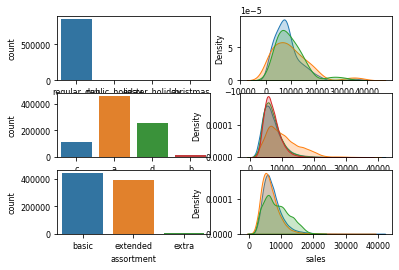

In [71]:
# state_holiday
plt.subplot(3, 2, 1)
lines = df4['state_holiday'] != 'regular_holiday'
df4_aux = df4.loc[lines, ['state_holiday']].reset_index(drop=True)
sns.countplot(df4_aux, x='state_holiday');

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)

# store_type
plt.subplot(3, 2, 3)
sns.countplot(df4, x='store_type');

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)

# assortment
plt.subplot(3, 2, 5)
sns.countplot(df4, x='assortment');

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)

## 4.2. Análise Bivariada

### **1.** Lojas com maior sortimentos deveriam vender mais.
**FALSO** Lojas com maior sortimento vendem MENOS

<AxesSubplot:xlabel='year_week'>

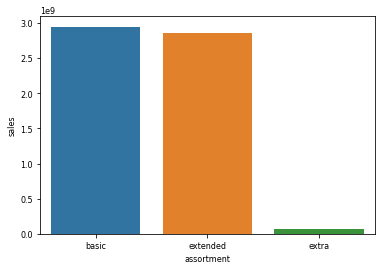

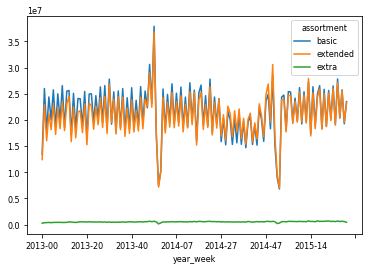

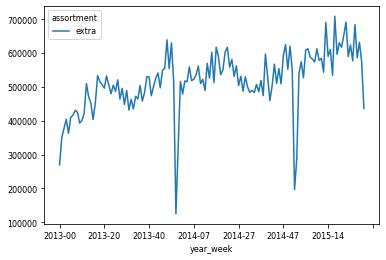

In [72]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux3 = aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

In [73]:
aux2.head()

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693


In [74]:
aux3.head()

,year_week,assortment,sales
2,2013-00,extra,269404
5,2013-01,extra,350279
8,2013-02,extra,377207
11,2013-03,extra,404662
14,2013-04,extra,363061


### **2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSO** Lojas com competidores mais próximos vendem MAIS

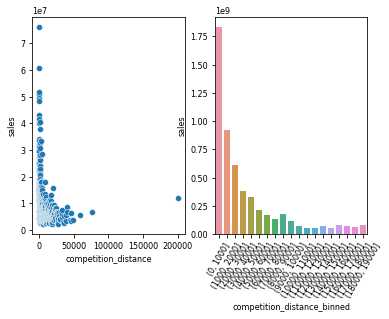

In [75]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,2,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,2,2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=60);

### **3.** Lojas com competidores há mais tempo deveriam vendem mais.
**FALSO** Lojas com competidores há mais tempo vendem MENOS

<AxesSubplot:>

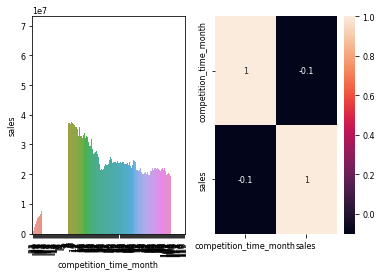

In [76]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

plt.subplot(1,2,1)
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,2,2)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSO** Lojas com promoções ativas pro mais tempo vendem MENOS depois de um certo período de promoção.

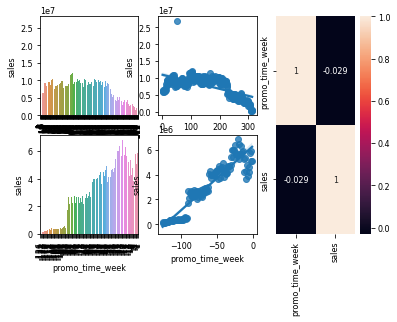

In [77]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0]   # promo extandida
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0]   # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s>**5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **6.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promoções consecutivas vendem MENOS

In [78]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


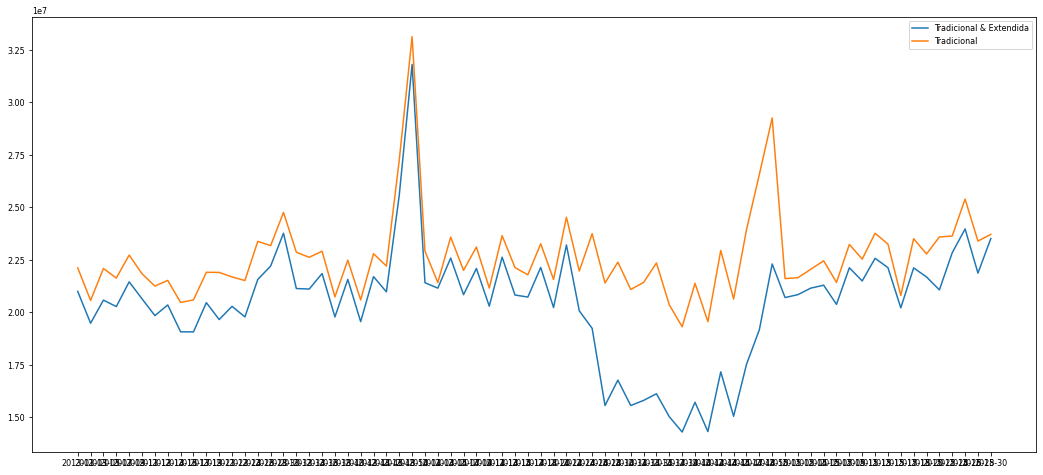

In [79]:
cols = ['year_week', 'sales']

lines = (df4['promo'] == 1) & (df4['promo2'] == 1)
aux1 = df4.loc[lines, cols].groupby('year_week').sum().reset_index()

lines = (df4['promo'] == 1) & (df4['promo2'] == 0)
aux2 = df4.loc[lines, cols].groupby('year_week').sum().reset_index()

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(aux1['year_week'], aux1['sales'], label='Tradicional & Extendida')
ax.plot(aux2['year_week'], aux2['sales'], label='Tradicional')
ax.legend()

In [80]:
aux1

,year_week,sales
0,2013-01,20995409
1,2013-03,19481514
2,2013-05,20580811
3,2013-07,20273185
4,2013-09,21451952
...,...,...
67,2015-22,21069133
68,2015-24,22839486
69,2015-26,23972605
70,2015-28,21867757


### **7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSO** Lojas abertas no Natal vendem MENOS

<AxesSubplot:xlabel='year', ylabel='sales'>

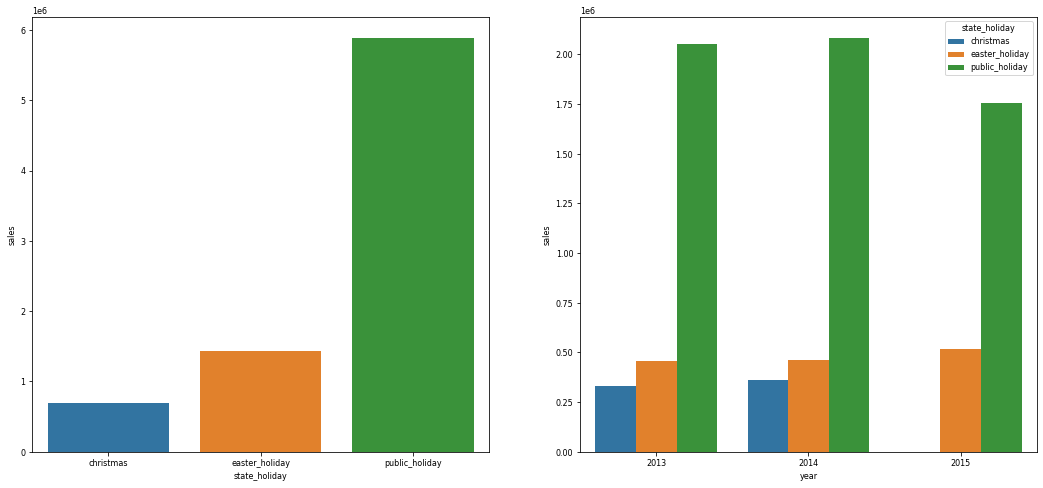

In [81]:
lines = (df4['state_holiday'] != 'regular_day')

cols1 = ['state_holiday', 'sales']
aux1 = df4.loc[lines, cols1].groupby('state_holiday').sum().reset_index()

cols2 = ['year', 'state_holiday', 'sales']
aux2 = df4.loc[lines, cols2].groupby(['year', 'state_holiday']).sum().reset_index()

fig, ax = plt.subplots(1,2, figsize=(18,8))
sns.barplot(ax=ax[0], data=aux1, x='state_holiday', y='sales')
sns.barplot(ax=ax[1], data=aux2, x='year', y='sales', hue='state_holiday')
#ax[0].bar(aux1['state_holiday'], aux1['sales'])
#ax[1].bar(aux2['year'], aux2['sales'])

In [82]:
aux2.head()

,year,state_holiday,sales
0,2013,christmas,331182
1,2013,easter_holiday,454997
2,2013,public_holiday,2052408
3,2014,christmas,360624
4,2014,easter_holiday,463353


### **8.** Lojas deveriam vender mais ao longo dos anos.
**FALSO** Lojas vendem menos ao longo dos anos

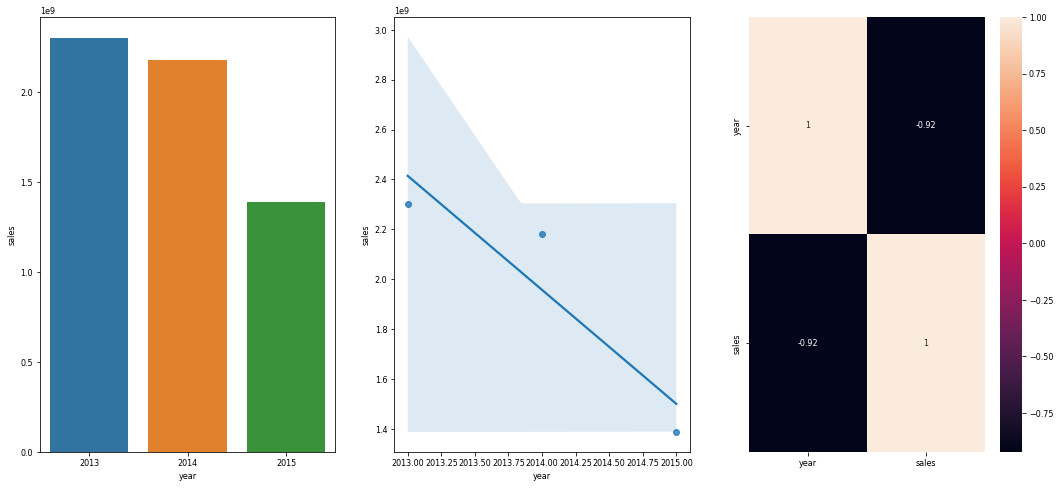

In [83]:
#lines = (df4['state_holiday'] != 'regular_day')

cols1 = ['year', 'sales']
aux1 = df4.loc[:, cols1].groupby('year').sum().reset_index()

fig, ax = plt.subplots(1,3, figsize=(18,8))
sns.barplot(ax=ax[0], data=aux1, x='year', y='sales')
sns.regplot(ax=ax[1], data=aux1, x='year', y='sales')
sns.heatmap(aux1.corr(method='pearson'), ax=ax[2], annot=True);

### **9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSO** Lojas vendem menos no segundo semestre do ano

<AxesSubplot:>

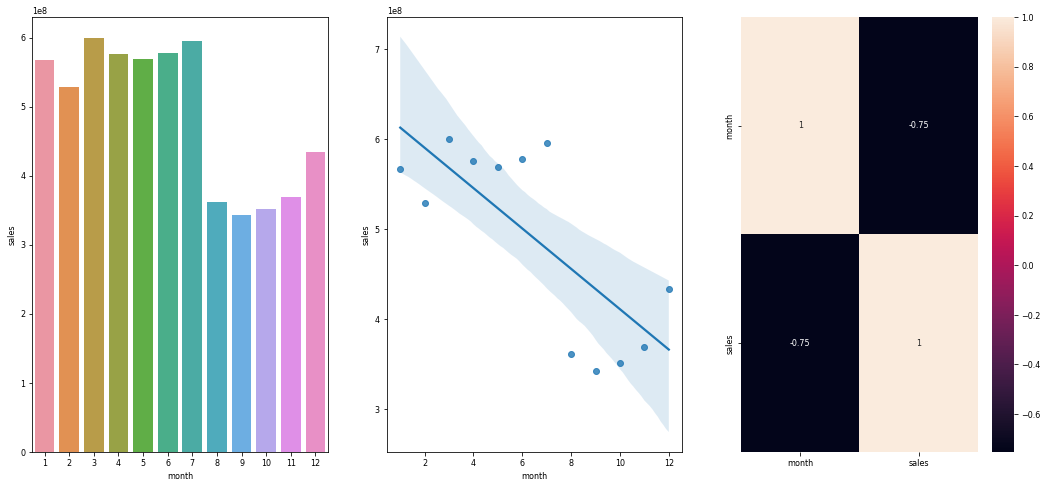

In [84]:
cols1 = ['month', 'sales']
aux1 = df4.loc[:, cols1].groupby('month').sum().reset_index()

fig, ax = plt.subplots(1,3, figsize=(18,8))
sns.barplot(ax=ax[0], data=aux1, x='month', y='sales')
sns.regplot(ax=ax[1], data=aux1, x='month', y='sales')
sns.heatmap(aux1.corr(method='pearson'), ax=ax[2], annot=True)

### **10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADE** Lojas vendem mais após o dia 10 de cada mês

<AxesSubplot:>

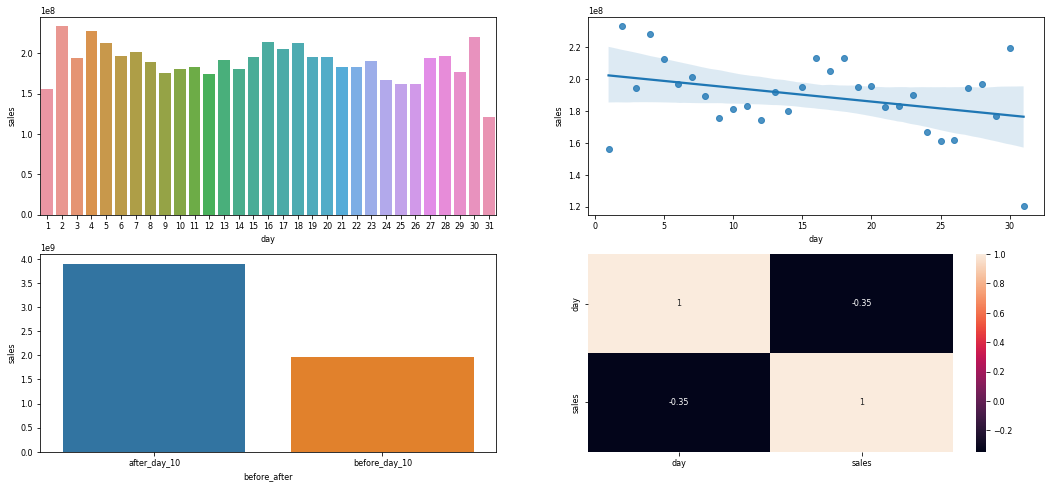

In [85]:
cols1 = ['day', 'sales']
aux1 = df4.loc[:, cols1].groupby('day').sum().reset_index()
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_day_10' if x <= 10 else 'after_day_10')

cols2 = ['before_after', 'sales']
aux2 = aux1.loc[:, cols2].groupby('before_after').sum().reset_index()

fig, ax = plt.subplots(2,2, figsize=(18,8))
sns.barplot(ax=ax[0,0], data=aux1, x='day', y='sales')
sns.regplot(ax=ax[0,1], data=aux1, x='day', y='sales')
sns.barplot(ax=ax[1,0], data=aux2, x='before_after', y='sales')
sns.heatmap(aux1[cols1].corr(method='pearson'), ax=ax[1,1], annot=True)

### **11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA**

<AxesSubplot:>

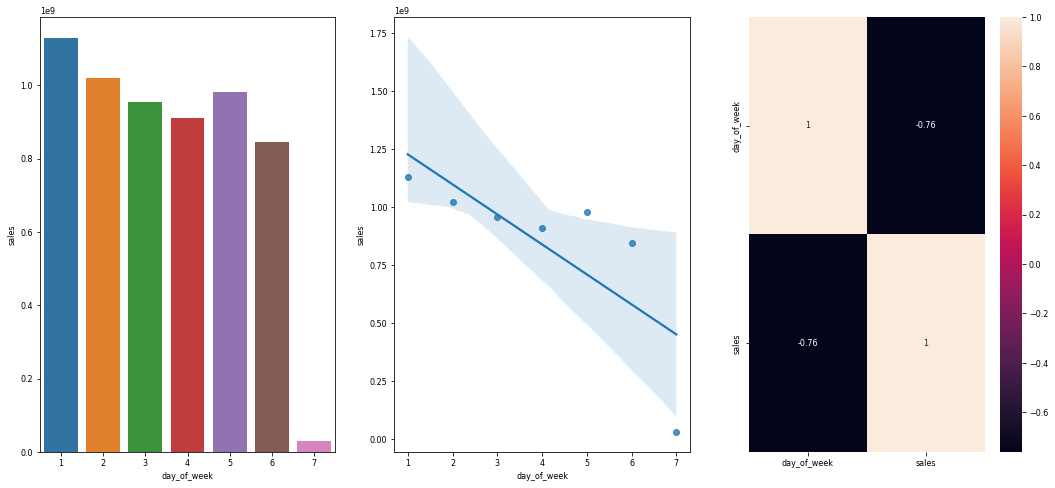

In [86]:
cols1 = ['day_of_week', 'sales']
aux1 = df4.loc[:, cols1].groupby('day_of_week').sum().reset_index()

fig, ax = plt.subplots(1,3, figsize=(18,8))
sns.barplot(ax=ax[0], data=aux1, x='day_of_week', y='sales')
sns.regplot(ax=ax[1], data=aux1, x='day_of_week', y='sales')
sns.heatmap(aux1.corr(method='pearson'), ax=ax[2], annot=True)

### **12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRO** Exceto em Julho e Agosto

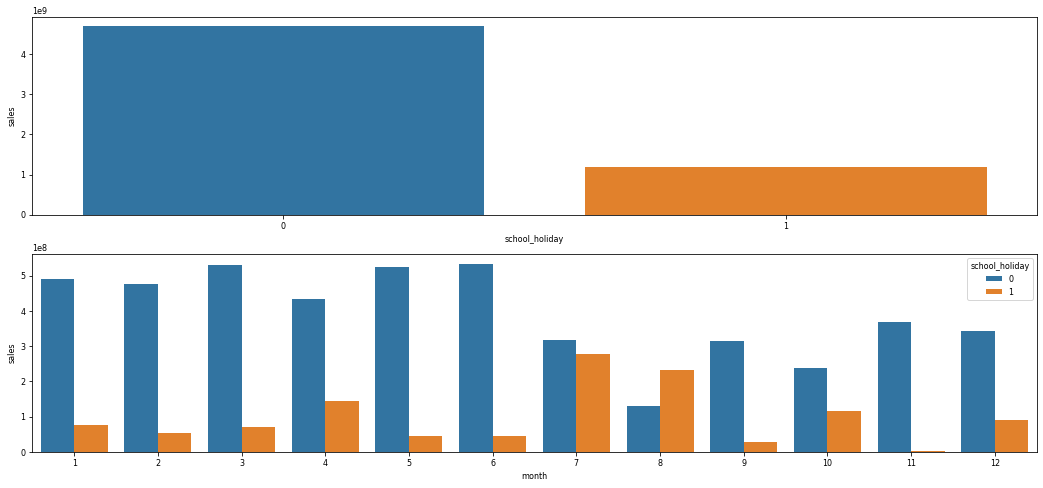

In [87]:
cols1 = ['school_holiday', 'sales']
aux1 = df4.loc[:, cols1].groupby('school_holiday').sum().reset_index()

cols2 = ['month', 'school_holiday', 'sales']
aux2 = df4.loc[:, cols2].groupby(['month', 'school_holiday']).sum().reset_index()

fig, ax = plt.subplots(2,1, figsize=(18,8))
sns.barplot(ax=ax[0], data=aux1, x='school_holiday', y='sales')
sns.barplot(ax=ax[1], data=aux2, x='month', y='sales', hue='school_holiday');

## 4.3. Análise Multivariada

### 4.3.1. Numerical Attributes

<AxesSubplot:>

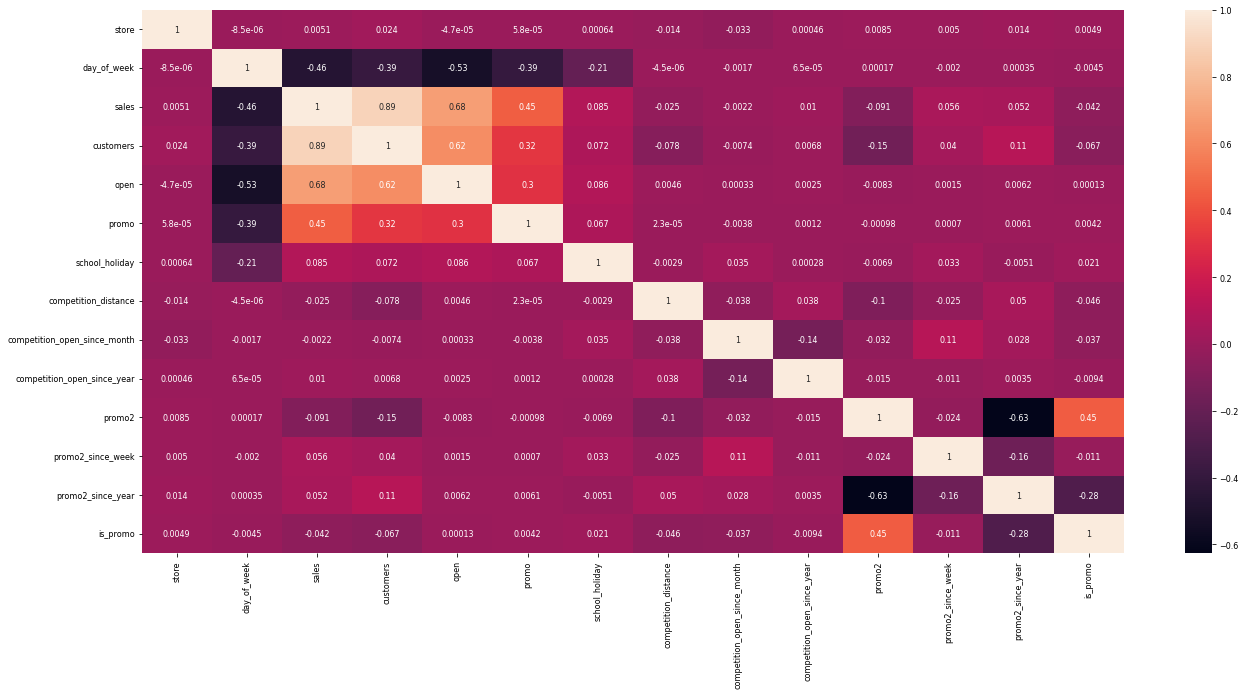

In [88]:
correlation = num_attributes.corr(method='pearson')

plt.figure(figsize=(22,10))
sns.heatmap(correlation, annot=True)

### 4.3.2. Categorical Attributes

In [89]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    phi2 = chi2 / n
    tilde_phi2 = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    tilde_k = k - (k - 1)**2 / (n - 1)
    tilde_r = r - (r - 1)**2 / (n - 1)
    return np.sqrt((tilde_phi2) / (min(tilde_k-1, tilde_r-1)))

<AxesSubplot:>

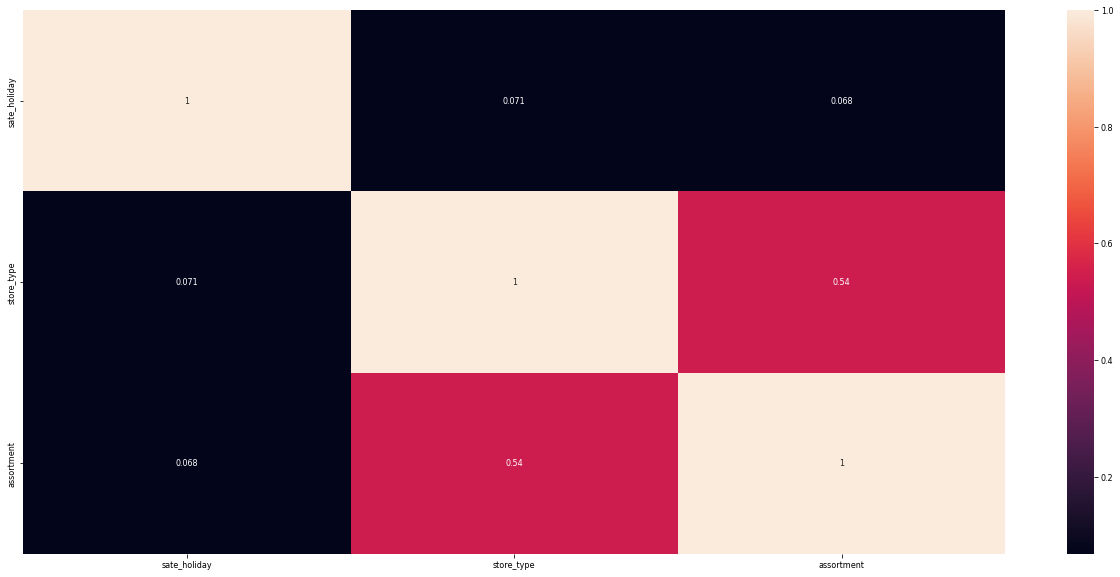

In [90]:
# Only cat attributes
aux1 = df4.select_dtypes(include='object')

a1 = cramer_v(aux1['state_holiday'], aux1['state_holiday'])
a2 = cramer_v(aux1['state_holiday'], aux1['store_type'])
a3 = cramer_v(aux1['state_holiday'], aux1['assortment'])

a4 = cramer_v(aux1['store_type'], aux1['state_holiday'])
a5 = cramer_v(aux1['store_type'], aux1['store_type'])
a6 = cramer_v(aux1['store_type'], aux1['assortment'])

a7 = cramer_v(aux1['assortment'], aux1['state_holiday'])
a8 = cramer_v(aux1['assortment'], aux1['store_type'])
a9 = cramer_v(aux1['assortment'], aux1['assortment'])

d = pd.DataFrame({'sate_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

plt.figure(figsize=(22,10))
sns.heatmap(d, annot=True)

# 5. Preparação dos Dados

In [91]:
df5 = df4.copy()

#del [df4, df4_aux]
#gc.collect()

35

## 5.1. Normalização

- Encontrar variáveis com uma distribuição normal
- Observando a seção 4.1.2. não encontramos variáveis com distribuição normal

## 5.2. Rescaling

- Uniformizar os ranges dos dados

In [92]:
aux1 = df5.select_dtypes(include=['int64', 'float64'])

Text(0.5, 1.0, 'promo_time_week')

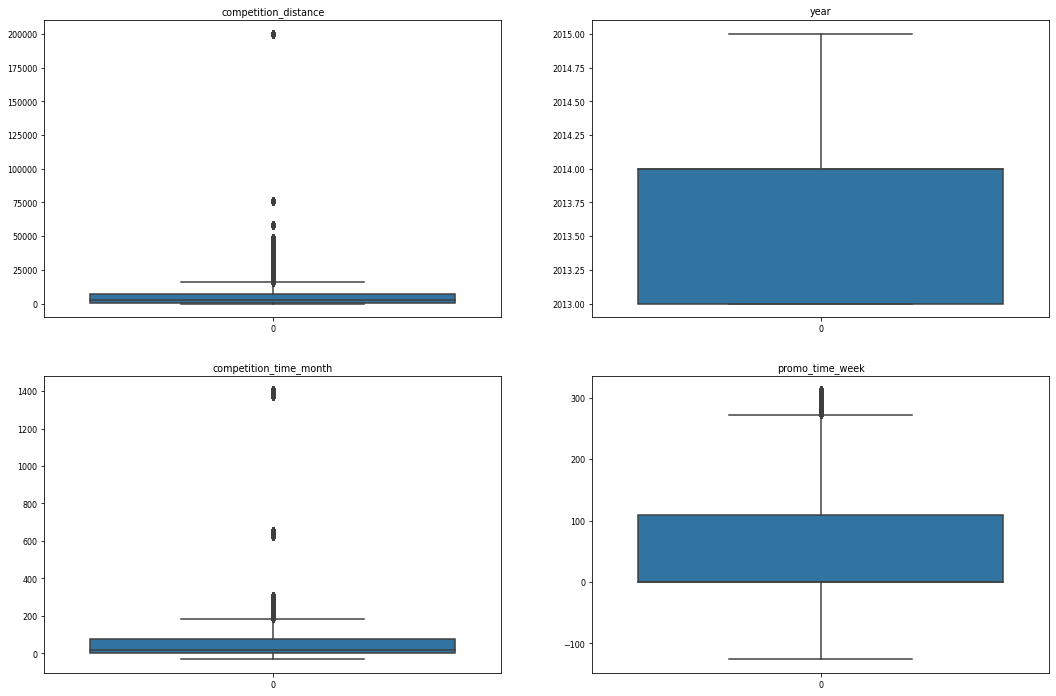

In [93]:
# competition_distance <-- outlier
# year
# competition_time_month <-- outlier
# promo_time_week

# Avaliando outliers
fig, ax = plt.subplots(2,2, figsize=(18,12))
sns.boxplot(aux1['competition_distance'], ax=ax[0,0])
sns.boxplot(aux1['year'], ax=ax[0,1])
sns.boxplot(aux1['competition_time_month'], ax=ax[1,0])
sns.boxplot(aux1['promo_time_week'], ax=ax[1,1])

ax[0,0].set_title('competition_distance')
ax[0,1].set_title('year')
ax[1,0].set_title('competition_time_month')
ax[1,1].set_title('promo_time_week')

In [125]:
rs = RobustScaler() # Quando possui outliers
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('../parameters/competition_distance_scaler.pkl', 'wb'))
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('../parameters/competition_time_month_scaler.pkl', 'wb'))

mms = MinMaxScaler()    # Quando outliers não são relevantes
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('../parameters/year_scaler.pkl', 'wb'))
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('../parameters/promo_time_week_scaler.pkl', 'wb'))

NameError: name 'df5' is not defined

## 5.3. Transformação

### 5.3.1. Encoding

In [96]:
# Categorical variables:

# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, columns=['state_holiday'])

# store_type
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('../parameters/store_type_scaler.pkl', 'wb'))

# assortment
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [ ]:
del le

### 5.3.2. Nature transformation

In [97]:
df5['sales'] = np.log1p(df5['sales'])

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi / 52)))

In [ ]:
df5.head()

# 6. Feature Selection

In [98]:
df6 = df5.copy()

del df5
gc.collect()

8927

In [ ]:
df6.head()

In [99]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

## 6.1. Split dataframe into training and test dataset

In [100]:
aux1 = df6[['store', 'date']].groupby('store').max().reset_index()
aux1['date'][0] - datetime.timedelta(days=6 * 7)

Timestamp('2015-06-19 00:00:00')

In [101]:
# training datasets
X_train = df6[df6['date'] < '2015-05-19']
y_train = X_train['sales']

# test datasets
X_test = df6[df6['date'] >= '2015-05-19']
y_test = X_test['sales']

In [ ]:
X_train.head()

## 6.2. Boruta as feature selector

In [102]:
# training and test dataset for Boruta
X_train_array = X_train.drop(['date', 'sales'], axis=1).values
y_train_array = y_train.values

# defining RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

In [ ]:
# defining Boruta ## takes about 4 hours!
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_array, y_train_array)

### 6.2.1. Best features from Boruta

In [ ]:
#cols_selected = boruta.support_.tolist()

#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()

## not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

#print(f'Colunas selecionadas: {cols_selected_boruta}')
#print(f'Colunas não selecionadas: {cols_not_selected_boruta}')

## 6.3. Manual Feature Selection

In [103]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7. Machine Learning Modelling

In [104]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

In [105]:
x_training = X_train[cols_selected_boruta_full]

In [106]:
del [X_train_array, y_train_array]
gc.collect()

0

## 7.1. Average Model

In [107]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE,MPE
0,Average Model,1338.88417,0.201574,1807.461166,-0.153491


## 7.2. Linear Regression Model

In [108]:
# model
lr = lm.LinearRegression()
lr.fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE,MPE
0,Linear Regression,1902.170294,0.285901,2730.18092,-0.059241


### 7.2.1. Linear Regression Model - Cross Validation

In [109]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2077.68 +/- 255.49,0.31 +/- 0.01,2932.47 +/- 400.64


## 7.3. Linear Regression Regularized Model

In [110]:
# model
lrr = lm.Lasso(alpha=0.01)
lrr.fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE,MPE
0,Linear Regression Lasso,1936.070186,0.283454,2811.723315,-0.036005


### 7.3.1. Lasso - Cross Validation

In [111]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2111.17 +/- 299.92,0.3 +/- 0.01,3042.07 +/- 444.46


In [112]:
del [aux1, aux2, aux3]

## 7.4. Random Forest Regressor

In [113]:
# model
rf = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)
rf.fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regression', np.expm1(y_test), np.expm1(yhat_rf))

#del [rf]
#gc.collect()

rf_result

,Model Name,MAE,MAPE,RMSE,MPE
0,Random Forest Regression,705.449554,0.10187,1033.477744,-0.008469


### 7.4.1. Random Forest - Cross Validation

In [ ]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest', rf, verbose=False)
rf_result_cv

## 7.5. XGBoost Regressor

In [114]:
# model
model_xgb = xgb.XGBRegressor(n_estimators=50)
model_xgb.fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regression', np.expm1(y_test), np.expm1(yhat_xgb))

#del model_xgb

xgb_result

,Model Name,MAE,MAPE,RMSE,MPE
0,XGBoost Regression,1172.16224,0.167289,1715.059935,-0.00728


### 7.5.1. XGBoost - Cross Validation

In [116]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regression', model_xgb, verbose=False)
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regression,1270.03 +/- 170.58,0.18 +/- 0.02,1814.91 +/- 208.25


## 7.6. Compare Model's Performance

In [ ]:
del num_attributes

### 7.6.1 Single Performance

In [117]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE,MPE
0,Random Forest Regression,705.449554,0.101870,1033.477744,-0.008469
0,XGBoost Regression,1172.162240,0.167289,1715.059935,-0.007280
0,Average Model,1338.884170,0.201574,1807.461166,-0.153491
0,Linear Regression,1902.170294,0.285901,2730.180920,-0.059241
0,Linear Regression Lasso,1936.070186,0.283454,2811.723315,-0.036005


### 7.6.2. Real Performance - Cross Validation

In [118]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

NameError: name 'rf_result_cv' is not defined

# 8. Hyperparameter Fine Tuning

## 8.1. Random Search

In [119]:
import random
import warnings
warnings.filterwarnings('ignore')

In [120]:
param = {'n_estimators': [15, 17, 25, 30, 35],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]}

MAX_EVAL = 2

In [121]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    # choose randomly the values for each paramter
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    print(hp)
    model_xgb = xgb.XGBRegressor(n_estimators=hp['n_estimators'],
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'])
    
    # performance
    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
    final_result = pd.concat([final_result, result])

final_result

{'n_estimators': 15, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 25, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7154.2 +/- 65.0,1.0 +/- 0.0,7805.36 +/- 43.68
0,XGBoost Regressor,7025.34 +/- 64.03,0.98 +/- 0.0,7683.23 +/- 42.44


## 8.2. Final Model

In [122]:
param_tuned = {'n_estimators': 30,
            'eta': 0.03,
            'max_depth': 5,
            'subsample': 0.5,
            'colsample_bytree': 0.9,
            'min_child_weight': 15}

#param_tuned = {'n_estimators': 3000,
#            'eta': 0.03,
#            'max_depth': 5,
#            'subsample': 0.7,
#            'colsample_bytree': 0.7,
#            'min_child_weight': 3}

#param_tuned = {'n_estimators': 100,
#            'eta': 0,
#            'max_depth': 0,
#            'subsample': 0,
#            'colsample_bytree': 0,
#            'min_child_weight': 0}

In [123]:
#model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
#                                 n_estimators=param_tuned['n_estimators'],
#                                 eta=param_tuned['eta'],
#                                 max_depth=param_tuned['max_depth'],
#                                 subsample=param_tuned['subsample'],
#                                 colsample_bytree=param_tuned['colsample_bytree'],
#                                 min_child_weight=param_tuned['min_child_weight'])

model_xgb_tuned = xgb.XGBRegressor()
    
model_xgb_tuned.fit(x_train, y_train)

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE,MPE
0,XGBoost Regressor,912.040267,0.130945,1314.437418,-0.003704


# 9. Interpretação do Erro

In [ ]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Buisiness Performance

In [ ]:
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mt.mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: "MAE"})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mt.mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: "MAPE"})

# merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [ ]:
df92

In [ ]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='store', y='MAPE', data=df92);

## 9.2. Total Performance

In [ ]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenarios', 0: 'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

## 9.3. Machine Learning Performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,15))
sns.lineplot(x='date', y='sales', data=df9, label='SALES', ax=ax[0,0])
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS', ax=ax[0,0])
sns.lineplot(x='date', y='error_rate', data=df9, label='SALES', ax=ax[0,1])
sns.distplot(df9['error'], ax=ax[1,0])
sns.scatterplot(x=df9['predictions'], y=df9['error'], data=df9, ax=ax[1,1])

# 10. Deploy Model to Production 

In [124]:
# saving trained model
pickle.dump(xgb_result_tuned, open('../parameters/model_rossmanm.pkl', 'wb'))

## 10.1. Rossmann Class

In [ ]:
class Rossmann(object):

    def __init__(self):
        self.competition_distance_scaler = pickle.load(open('../parameters/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open('../parameters/competition_time_month_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load(open('../parameters/year_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load(open('../parameters/promo_time_week_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load(open('../parameters/store_type_scaler.pkl', 'rb'))
        self.competition_distance_scaler = pickle.load(open('../parameters/competition_distance_scaler.pkl', 'rb'))

    def data_cleaning(self, df1): 

        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        # Função para colocar underscore para separar palavras
        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))           # O map passa os valores de cols_old para a função snakecase

        df1.columns = cols_new
        
        ## 1.3. Data Types
        df1['date'] = pd.to_datetime(df1['date'])      
    
        ## 1.5. Fill out NA
        #competition_distance - substituir os valores faltantes por distâncias muito grandes, indicando que não há competidores próximos
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if pd.isna(x)==True else x)

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if pd.isna(x['competition_open_since_month'])==True
                                                                                  else x['competition_open_since_month'], axis=1)

        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if pd.isna(x['competition_open_since_year'])==True
                                                                                  else x['competition_open_since_year'], axis=1)

        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if pd.isna(x['promo2_since_week'])==True
                                                                                  else x['promo2_since_week'], axis=1)

        #promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if pd.isna(x['promo2_since_year'])==True
                                                                                  else x['promo2_since_year'], axis=1)

        #promo_interval
        month_map = {1: 'Jan',
                     2: 'Feb',
                     3: 'Mar',
                     4: 'Apr',
                     5: 'May',
                     6: 'Jun',
                     7: 'Jul',
                     8: 'Aug',
                     9: 'Sep',
                     10: 'Oct',
                     11: 'Nov',
                     12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0
                                                           else 1 if x['month_map'] in x['promo_interval'].split(',')
                                                           else 0, axis=1)
        ## 1.6. Change Types
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

        return df1
    

    def feature_engineering(self, df2):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of the year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).dt.days.astype(int)

        # primo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1','%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).dt.days.astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')
        # 3. Filtragem de Variáveis
        
        ## 3.1. Filtragem das Linhas
        df2 = df2[(df2['open'] != 0) & (df2['sales'] > 0)]
        ## 3.2. Seleção das Colunas
        cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop,axis=1)

        return df2
    

    def data_preparation(self, df5):
    
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)
        
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
        
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)
        
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
        
        ### 5.3.1. Encoding
        # Categorical variables:

        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, columns=['state_holiday'])

        # store_type
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])
        
        # assortment
        assortment_dict = {'basic': 1,
                           'extra': 2,
                           'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)
        
        ### 5.3.2. Nature transformation
        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi / 52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi / 52)))

        cols_selected = ['store',
                            'promo',
                            'store_type',
                            'assortment',
                            'competition_distance',
                            'competition_open_since_month',
                            'competition_open_since_year',
                            'promo2',
                            'promo2_since_week',
                            'promo2_since_year',
                            'competition_time_month',
                            'promo_time_week',
                            'day_of_week_sin',
                            'day_of_week_cos',
                            'month_sin',
                            'month_cos',
                            'day_sin',
                            'day_cos',
                            'week_of_year_sin',
                            'week_of_year_cos']
        
        return df5[cols_selected]

## 10.2. API Handler

In [ ]:
import pandas as pd
import pickle
from flask import Flask, request, Response

from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load(open('/home/ezequiel/Documentos/Prejetos_Data_Science/DS_em_producao/model/model_rossmann.pkl', 'rb'))

# initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()

    if test_json: # there is data

        if isinstance(test_json, dict): # unique example
            test_raw = pd.DataFrame(test_json, index=[0])

        else:   # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        pipeline = Rossmann()
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        # data preparation
        df3 = pipeline.data_preparation(df2)
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        return df_response

    else:

        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0')

## 10.3. API Tester